# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nuans_minihw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = './'
ni_dataset_path = os.path.join(app_root, 'datasets', 'nominal_iden_dataset')

ni_train_path = os.path.join(ni_dataset_path, 'train.tsv')
ni_valid_path = os.path.join(ni_dataset_path, 'valid.tsv')
checkpoints = os.path.join(app_root, 'checkpoints')

In [3]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "xlm-roberta-base",
    'fine_tune_transformer': True,
}

In [6]:
import matplotlib.pyplot as plt

def print_summary(model, only_params = False):
    if not only_params:
        print(model)
        print('----------------------')
    p = sum(p.numel() for p in model.parameters())
    tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ntp = p - tp
    print('parameters:', f'{p:,}')
    print('trainable parameters:', f'{tp:,}')
    print('non-trainable parameters:', f'{ntp:,}')

def display_history(dict_history):
    plt.figure(figsize=(8,8))
    for name, hist in dict_history.items():
        plt.plot([i for i in range(len(hist))], hist, label=name)
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title('Model learning')
    plt.legend()
    plt.show()

# Dataset

In [7]:
from torch.utils.data import Dataset

class NIDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        event_name = self.data[idx][0]
        event_desc = self.data[idx][1]
        event_label = self.data[idx][2]
        sample = {
            'text': event_desc, 
            'text_pair': event_name, 
            'label': int(event_label)}
        return sample

    @staticmethod
    def create_collate_fn():
        def collate_fn(batch):
            batch_formatted = {
                'text':[sample['text'] for sample in batch], 
                'label':[sample['label'] for sample in batch]
            }
            return batch_formatted

In [8]:
ni_train = []
with open( ni_train_path ) as file:
    for line in file:
        l = line.strip('\n').split('\t')
        ni_train.append(l)

ni_valid = []
with open( ni_valid_path ) as file:
    for line in file:
        l = line.strip('\n').split('\t')
        ni_valid.append(l)

In [9]:
ni_train

[['tolerance', 'the act of tolerating something', '1', 'tolerance.n.03'],
 ['allowance', 'the act of allowing', '1', 'allowance.n.06'],
 ['license',
  'the act of giving a formal (usually written) authorization',
  '1',
  'license.n.04'],
 ['authorization',
  'the act of conferring legality or sanction or formal warrant',
  '1',
  'authorization.n.04'],
 ['management', 'the act of managing something', '1', 'management.n.01'],
 ['social control',
  'control exerted (actively or passively) by group action',
  '1',
  'social_control.n.01'],
 ['group action',
  'action taken by a group of people',
  '1',
  'group_action.n.01'],
 ['act', 'something that people do or cause to happen', '1', 'act.n.02'],
 ['event',
  'something that happens at a given place and time',
  '1',
  'event.n.01'],
 ['abidance',
  'the act of abiding (enduring without yielding)',
  '1',
  'abidance.n.03'],
 ['continuance',
  'the act of continuing an activity without interruption',
  '1',
  'continuance.n.01'],
 ['ac

In [10]:
ni_train_dataset = NIDataset(ni_train)
ni_valid_dataset = NIDataset(ni_valid)

In [11]:
from torch.utils.data import DataLoader
ni_train_dataloader = DataLoader(
    ni_train_dataset, 
    batch_size=global_params['batch_size'], 
    collate_fn=NIDataset.create_collate_fn(),
    shuffle=True)
ni_valid_dataloader = DataLoader(
    ni_valid_dataset, 
    batch_size=global_params['batch_size'], 
    collate_fn=NIDataset.create_collate_fn(),
    shuffle=False)

In [12]:
loss_function = torch.nn.BCELoss()

# Training the XLM-RoBERTa based model

In [13]:
from code_files.models.nominal_event_identificator import NEIdentificator
from code_files.utils.Trainer_nei import Trainer_nei
import torch.optim as optim

In [14]:
nei_model = NEIdentificator(hparams = global_params, loss_fn = loss_function)
optimizer = optim.SGD(nei_model.parameters(), lr=0.0016, momentum=0.9)
print_summary(nei_model, True)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


parameters: 278,339,329
trainable parameters: 295,681
non-trainable parameters: 278,043,648


In [15]:
history = {}

In [16]:
trainer = Trainer_nei()

history = trainer.train(
    nei_model, optimizer, ni_train_dataloader, ni_valid_dataloader,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.5,
    save_path_name=os.path.join(checkpoints, 'nei_roberta.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.699923
# Validation loss => 0.691919 #
Epoch   1 => avg_loss: 0.697443
# Validation loss => 0.692136 #
Epoch   2 => avg_loss: 0.696396
# Validation loss => 0.690568 #
Epoch   3 => avg_loss: 0.694701
# Validation loss => 0.690836 #
Epoch   4 => avg_loss: 0.690093
# Validation loss => 0.699308 #
Epoch   5 => avg_loss: 0.690264
# Validation loss => 0.690359 #
Epoch   6 => avg_loss: 0.685765
# Validation loss => 0.692723 #
Epoch   7 => avg_loss: 0.687335
# Validation loss => 0.698857 #


KeyboardInterrupt: 

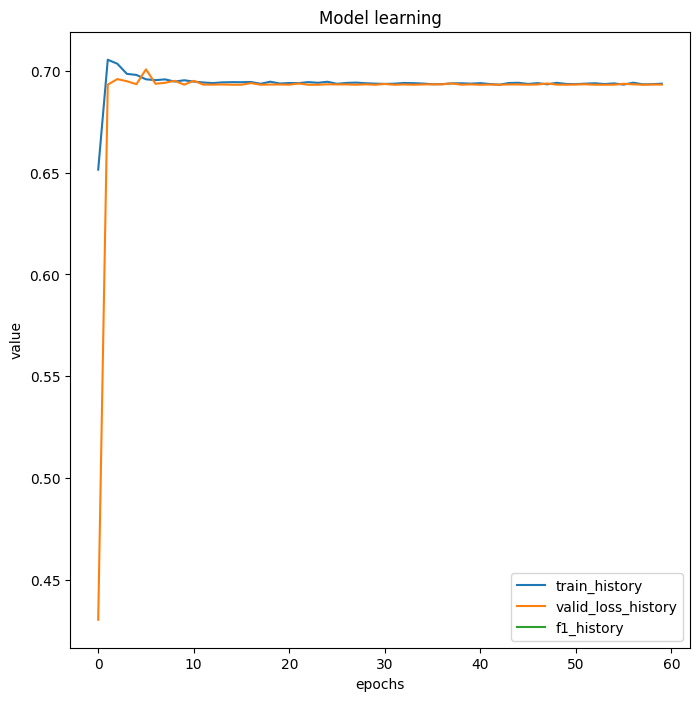

In [ ]:
display_history(history)